In [18]:
!pip install -r requirements.txt

### 1. Import Dependencies

In [19]:
import os
import numpy as np
import pandas as pd # alias
import seaborn as sns
import matplotlib.pyplot as plt

### 2. basic processing

In [20]:
df = pd.read_csv('data/processed/ChurnModelling_Missing_Values_Handled.csv')
df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [21]:
print(f"No of Rows : {len(df)}")

No of Rows : 7043


### 3. outlier detection techniques

#### 3.1 distribution plots

In [22]:
categorical_columns = [
                        'gender', 'SeniorCitizen',
                        'Partner', 'Dependents',
                        'PhoneService', 'MultipleLines', 
                        'InternetService',
                        'OnlineSecurity', 'OnlineBackup',
                        'DeviceProtection', 'TechSupport',
                        'StreamingTV', 'StreamingMovies',
                        'Contract', 'PaperlessBilling',
                        'PaymentMethod', 'Churn'
                        ]

numerical_columns = [
                    'tenure', 'MonthlyCharges',
					'TotalCharges'
                    ]

In [23]:
print(df[numerical_columns].dtypes)

tenure              int64
MonthlyCharges    float64
TotalCharges      float64
dtype: object


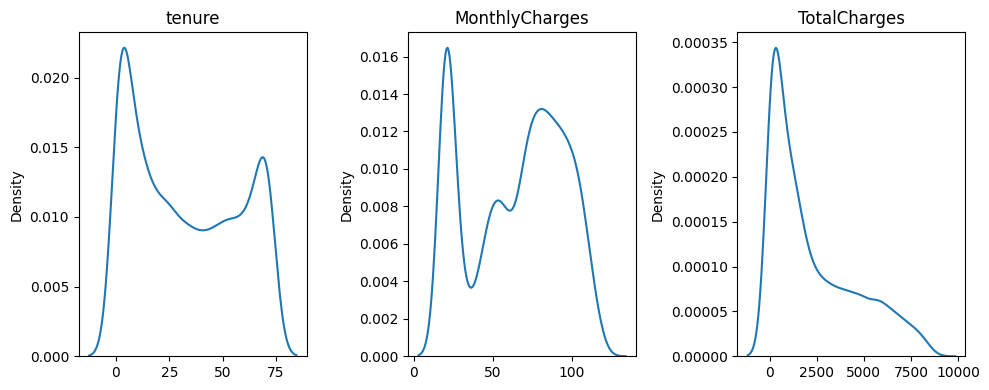

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
axes = axes.flatten()

for idx, col in enumerate(numerical_columns):
    sns.kdeplot(
        x=df[col],
        ax=axes[idx],
    )
    axes[idx].set_title(col)
    axes[idx].set_xlabel('')

plt.tight_layout()
plt.show()


Bimodal

There are lot of people with 0 balance in the bank account and the people who manage their account has a normal distribution


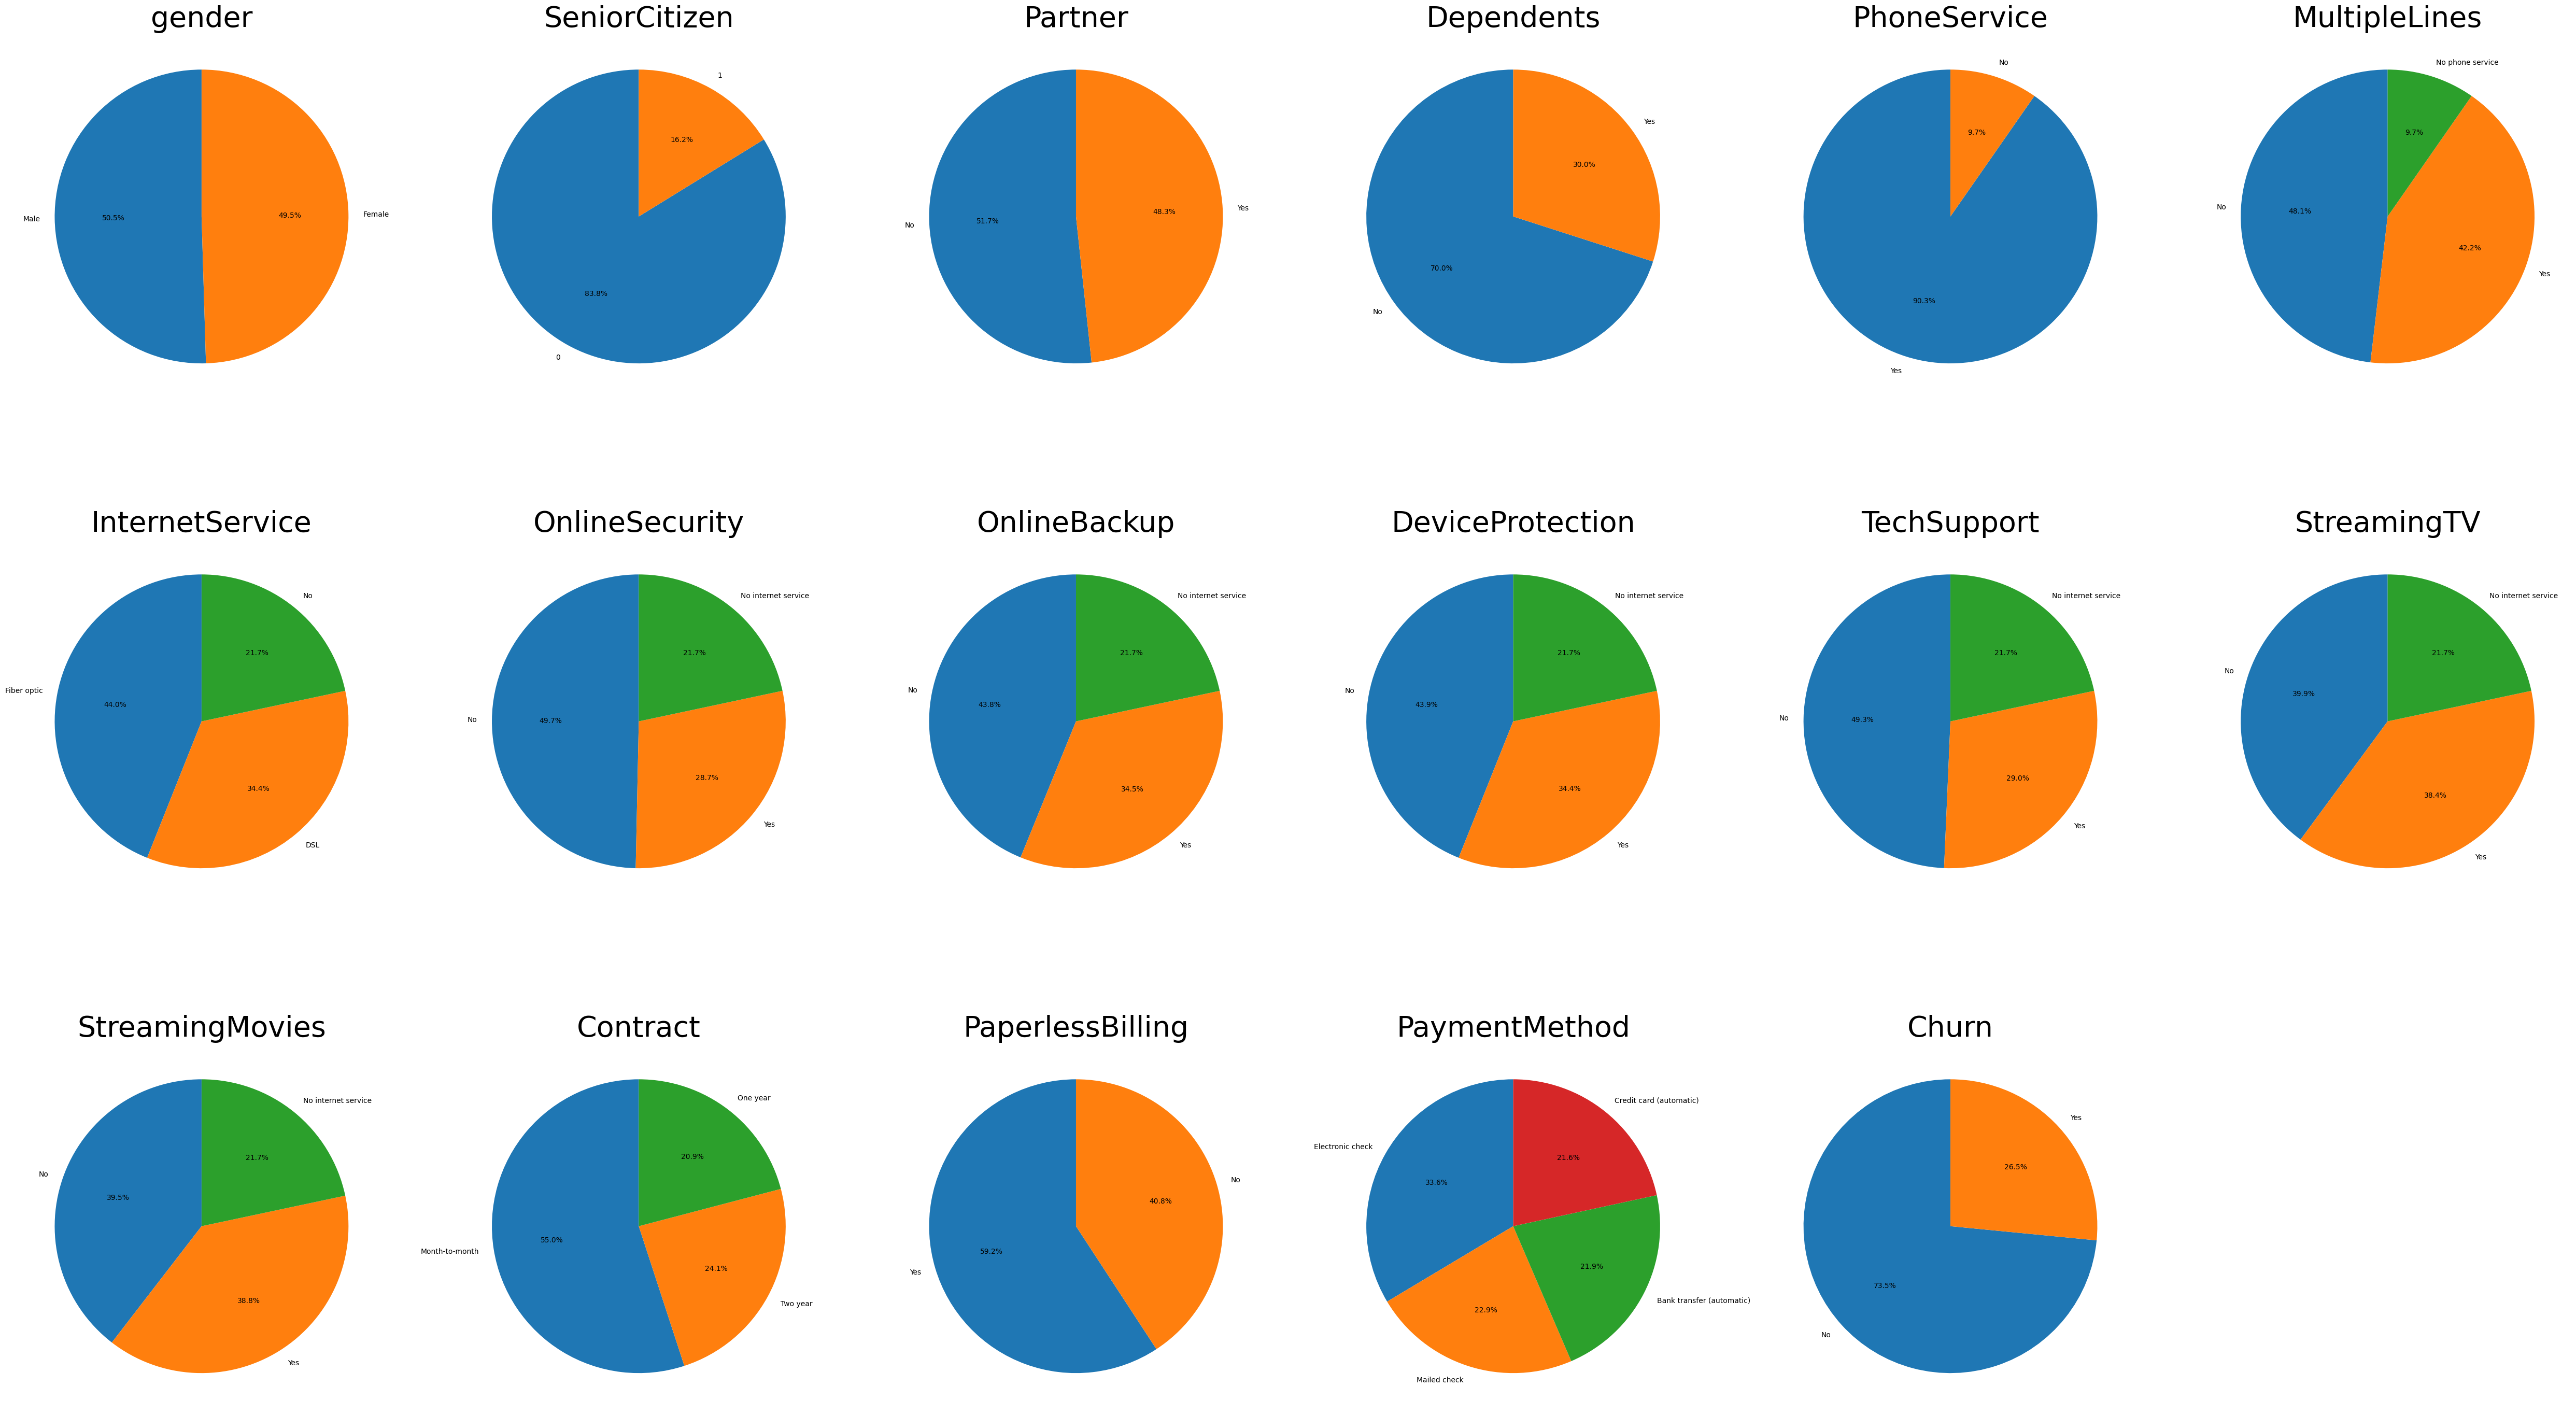

In [25]:
fig, axes = plt.subplots(3, 6, figsize=(50, 30))  # much larger canvas
axes = axes.flatten()

for idx, col in enumerate(categorical_columns):
    df[col].value_counts().plot(
        kind='pie',
        ax=axes[idx],
        autopct='%1.1f%%',
        startangle=90
    )
    axes[idx].set_ylabel('')
    axes[idx].set_title(col, fontsize=40)

# Hide unused subplot
for j in range(len(categorical_columns), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


#### 3.2 box plots

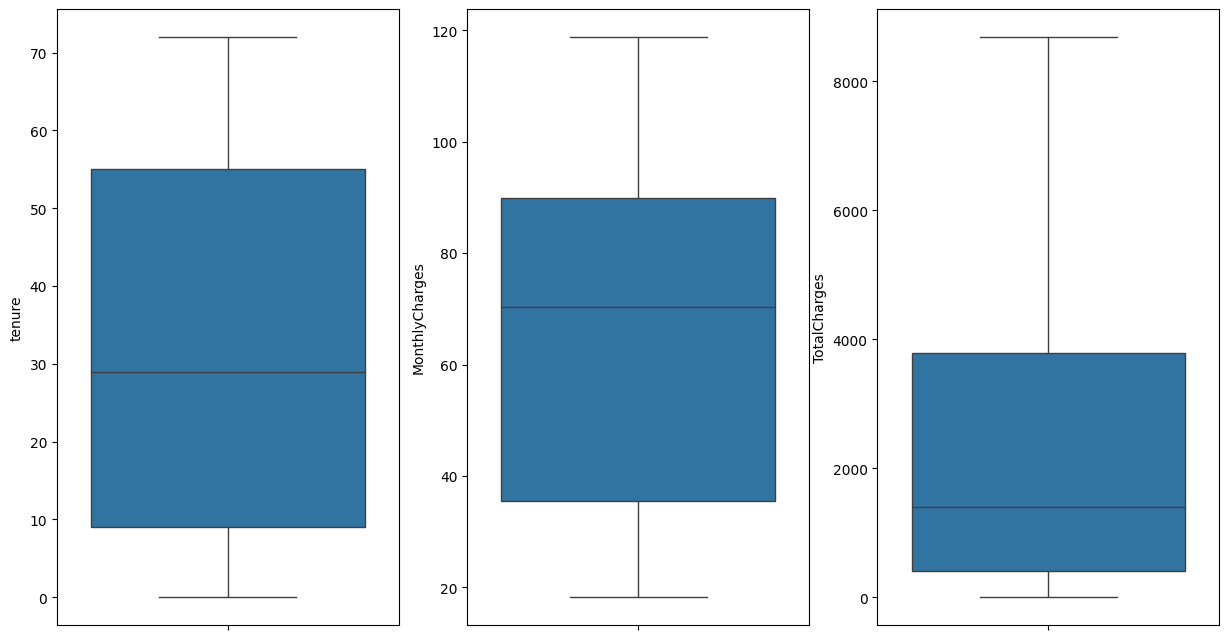

In [26]:
numerical_columns = [
                    'tenure', 'MonthlyCharges',
					'TotalCharges'
                    ]

fig, axes = plt.subplots(1, 3, figsize=(15, 8))

sns.boxplot(data=df['tenure'], ax=axes[0])
sns.boxplot(data=df['MonthlyCharges'], ax=axes[1])
sns.boxplot(data=df['TotalCharges'], ax=axes[2])

plt.show()

#### 3.3 empirical rule / 3-sigma rule

In [27]:
def find_anomaly(data):
    
    mean = data.mean()
    std = data.std()

    upper_bound = mean + 3 * std
    lower_bound = mean - 3 * std
    
    return (data > upper_bound) | (data < lower_bound)


In [28]:
numerical_columns = [
                    'tenure', 'MonthlyCharges',
					'TotalCharges'
                    ]

for col in numerical_columns:
    n_outliers = find_anomaly(df[col]).sum()
    n_outlier_percentage = round(n_outliers / len(df), 3)
    print(f"{col} : {n_outliers} outliers ({n_outlier_percentage}% )")

tenure : 0 outliers (0.0% )
MonthlyCharges : 0 outliers (0.0% )
TotalCharges : 0 outliers (0.0% )


#### 3.4 IQR Method 

In [29]:
def find_anomaly(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)

    IQR = Q3 - Q1

    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR

    return (data > upper_bound) | (data < lower_bound)



In [30]:
numerical_columns = [
                    'tenure', 'MonthlyCharges',
					'TotalCharges'
                    ]

for col in numerical_columns:
    n_outliers = find_anomaly(df[col]).sum()
    n_outlier_percentage = round(n_outliers / len(df), 3)
    print(f"{col} : {n_outliers} outliers ({n_outlier_percentage} %)")

tenure : 0 outliers (0.0 %)
MonthlyCharges : 0 outliers (0.0 %)
TotalCharges : 0 outliers (0.0 %)


In [31]:
outlier_mask_log = pd.DataFrame()
for col in numerical_columns:
    outlier_mask_log[col] = find_anomaly(df[col])

outlier_count = outlier_mask_log.sum(axis=1)
outlier_mask_log['Outlier Count'] = outlier_count
outlier_mask_log = outlier_mask_log[outlier_mask_log['Outlier Count'] > 1]
outlier_mask_log

,tenure,MonthlyCharges,TotalCharges,Outlier Count


In [32]:
df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [33]:
df.to_csv('data/processed/ChurnModelling_Outliers_Handled.csv', index=False)